Notebook where we plot everything related to the weight maps (phenotypes). This includes Figure 4, Figure S2 , Figure S3 and tables.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.colors as colors
import subprocess
import seaborn as sns

import nibabel as nib
from scipy.io import loadmat
from os.path import join as opj
import h5py
import os
from nilearn import plotting, image, datasets
from pathlib import Path
import h5py

from scipy.spatial.distance import squareform
from matplotlib.colors import ListedColormap

In [2]:
%matplotlib inline

Load data previously stored with the weights

In [3]:
f =  h5py.File(opj('../results', "weights_phenotypes.hdf5"), "r") # weight results

Create folder where to store the phenotypes figures

In [4]:
pheno_plot_folder = Path(opj('../plots/', 'neurophenotypes'))
pheno_plot_folder.mkdir(parents=True, exist_ok=True)

Load and define data about the parcellation used

In [126]:
# In-house cifti file of type pscalar of the Cole parcellation, i.e.
# each parcel corresponds to a number when you look at it in wb_view
cole_pscalar_img = opj("../data", "CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR.pscalar.nii")

# Cole parcellation in volumetric version. Downloaded from 
# Cole's Lab repo and used only for visualisation purposes
cole_vol_img = image.load_img(opj("../data/MMP_in_MNI_corr.nii.gz"))

# Assignment of each parcel to one of the 12 Intrinsic functional networks
netassignments = np.loadtxt(opj("../data", "cortex_subcortex_parcel_network_assignments.txt"))

# Network order (Need to subtract one to make it compatible for python indices)
indsort = np.loadtxt(opj("../data", "cortex_subcortex_community_order.txt"),dtype=int) - 1 

# Network labels and colours according to Cole Lab repository
rsn_labels = ['Primary Visual', 'Secondary Visual', 'Somatomotor', 
              'Cingulo-Opercular', 'Dorsal-attention', 'Language', 
              'Frontoparietal', 'Auditory', 'Default Mode',
              'Posterior-Multimodal', 'Ventral-Multimodal', 'Orbito-Affective']
              
rsn_colours = [(0, 0, 255, 255), (100, 0, 255, 255), (0, 255, 255, 255),
               (153, 0, 153, 255), (0, 255, 0, 255), (0, 154, 154, 255), 
               (255, 255, 0, 255),  (249, 61, 251, 255), (255, 0, 0, 255), 
               (177, 89, 40, 255), (255, 156, 0, 255), (65, 124, 0, 255)
              ]
# Normalise these colours and pass them to a palette of colours to be used in matplotlib
rsn_norm_colours = [(rgb[0]/255, rgb[1]/255, rgb[2]/255, rgb[3]/255) for rgb in rsn_colours]
rsn_cmap = ListedColormap(rsn_norm_colours)

# Parcellation info file
parcel_info = pd.read_csv(opj("../data",
                              'CortexSubcortex_ColeAnticevic_NetPartition_wSubcorGSR_parcels_LR_LabelKey.txt'),
                          sep='\t')
# Name of the parcel according to original Cole's Lab definition
parcel_labels = parcel_info['LABEL'].to_list()

In [7]:
sns.set(font="Arial")

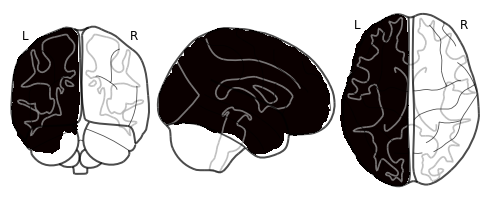

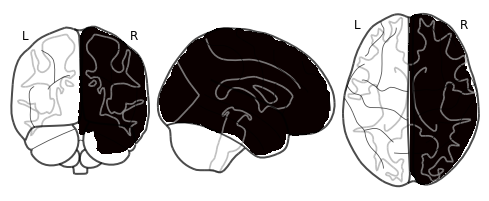

In [84]:
# In the volumetric version of Cole Atlas, left hemisphere parcels go from 1 to 180
# and right hemisphere parcels from 201 to 380
plotting.plot_glass_brain(image.math_img("(img>0)*(img<200)", img = cole_vol_img))
plotting.plot_glass_brain(image.math_img("img>200", img = cole_vol_img))

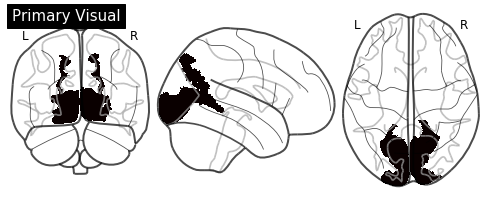

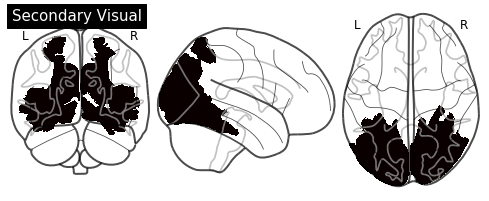

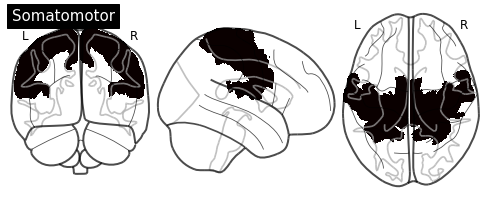

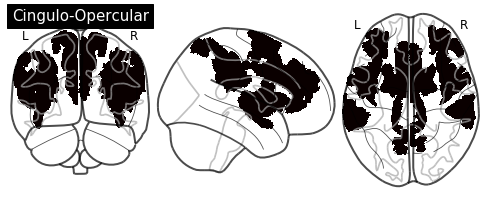

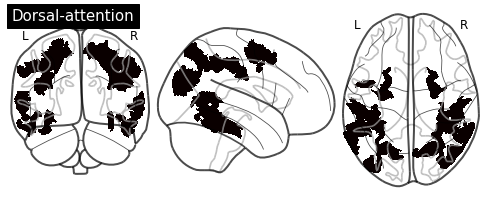

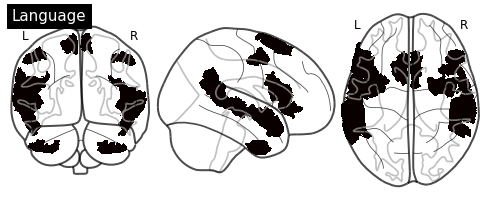

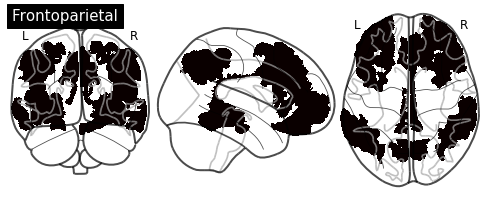

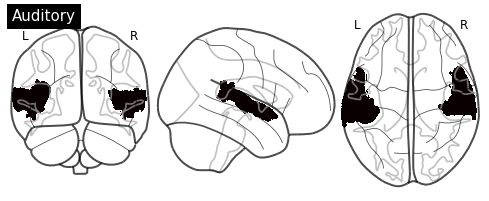

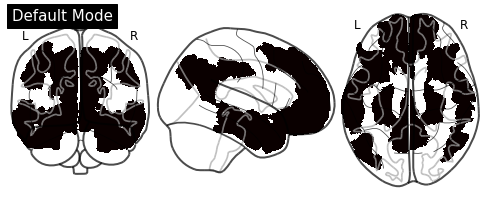

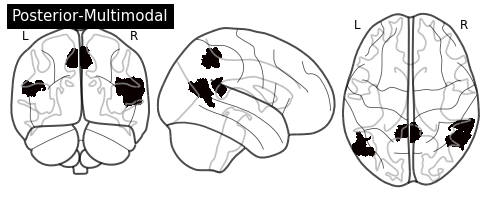

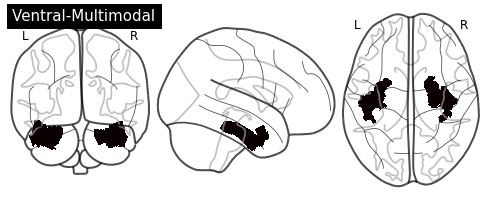

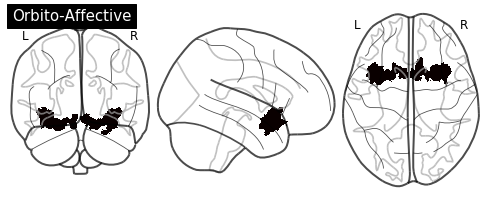

In [127]:
for ii in range(1, 13):
    plotting.plot_glass_brain(image.math_img("img==%d" % ii, img=foo), title=rsn_labels[ii-1])

Load and define a few things needed for plotting the local connectome weight maps

In [886]:
# load the MNI152 T1 template
mni152_template = datasets.load_mni152_template()

# Load local connectome coordinates in this template
mni_location = np.loadtxt(opj("../data", "local_connectome_mni_coordinates.txt"), dtype=np.int16)

In [7]:
# Atlas of white matter tracts (Yeh 2018). This is just for tract-wise average weights for supp. material
tract_atlas = nib.load(opj("../data" ,'HCP842_tractography.nii.gz'))
tract_atlas_labels = pd.read_csv(opj("../data", 'HCP842_tractography.txt'), header=None, sep="\t").iloc[:,1]

Just for visualisation, plot the masks for the 10 first tracts

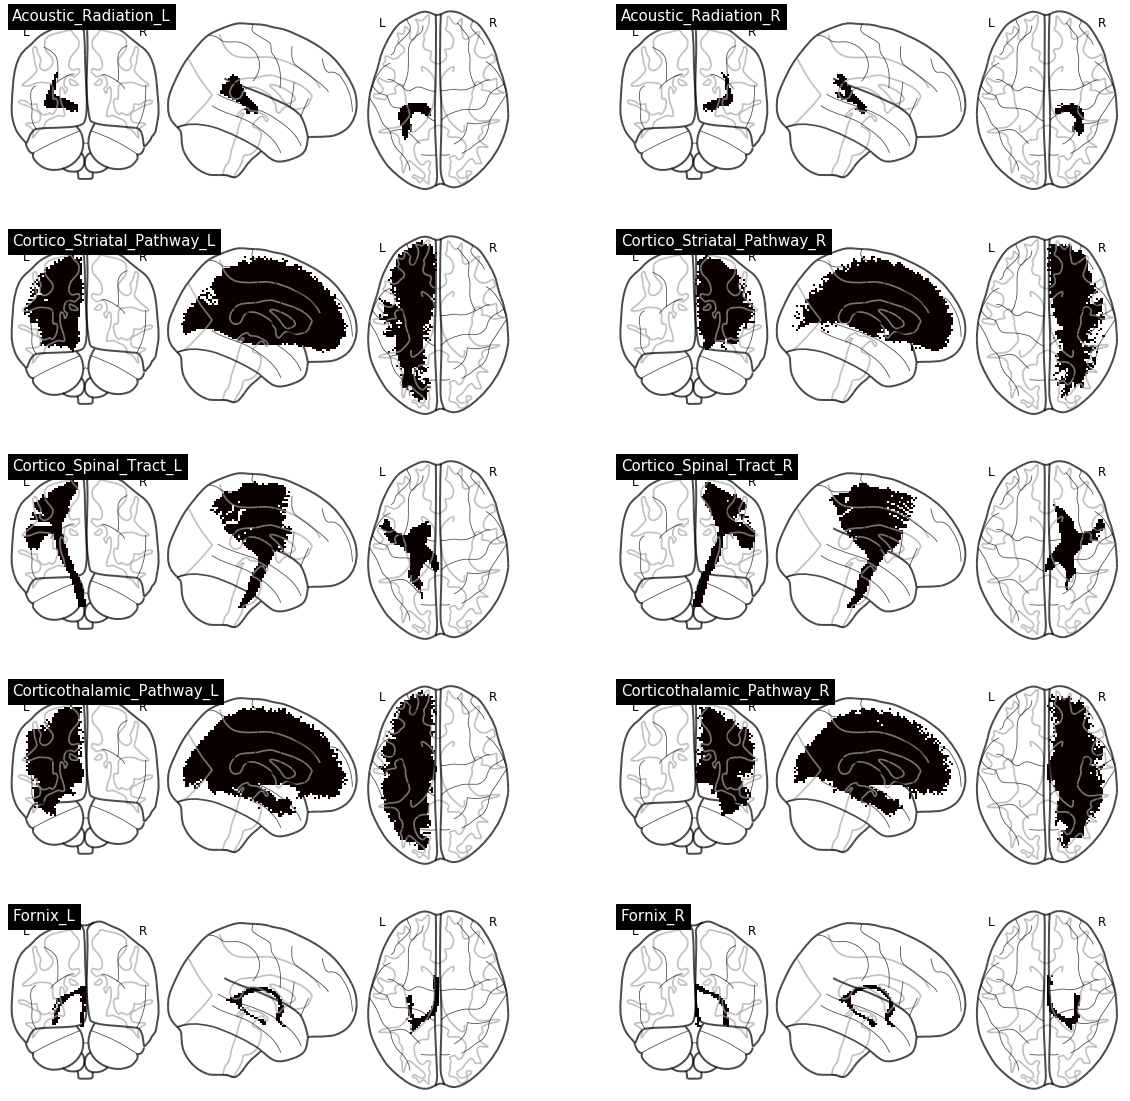

In [8]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(20, 20))
axs = axs.flatten()
for ii in range(10):

    source_img = image.index_img(tract_atlas, ii)
    plotting.plot_glass_brain(image.resample_to_img(source_img, mni152_template, interpolation='nearest'), 
                              axes=axs[ii], title = tract_atlas_labels[ii]
                             )

Some further definitions for their use througout the manuscript

In [46]:
# Name of test scores
score_names = ['Cognitive Function Composite',
               'Fluid Cognition Composite', 
               'Crystallized Cognition Composite', 
               'Short Penn CPT Sensitivity', 
               'Delay Discounting:\n AUC for Discounting of $200', 
               'Penn Word Memory: \n Total Number of Correct Responses', 
               'Penn Line Orientation: \n Total Number Correct']
# Name of single-channels
modality_names = ['RESTING-STATE \n CONNECTIVITY', 'CORTICAL \n SURFACE', 
                  'CORTICAL \n THICKNESS', 'SUBCORTICAL \n VOLUME', 'LOCAL \n CONNECTOME']

n_scores = len(score_names)
n_mods = len(modality_names)

Here some operations for plotting the local connectome phenotypes

In [887]:
#Pass mni coordinates to voxel coordinates
def from_mni_to_voxel(x, y, z):

    origin = [45, 63, 36]; #% [X Y Z]

    vs = 2
    x= origin[0] - x/vs
    y= y/vs + origin[1]
    z= z/vs + origin[2]

    return x, y, z

#compute the local connectome fingreprint coordinates into voxel system of reference
voxel_location = np.array([from_mni_to_voxel(x, y, z) for x, y, z in mni_location])

# Count repeated voxels to latter average on the local connectome feature weights
rep_img = np.zeros_like(mni152_template.get_fdata())

for ii, (x, y, z) in enumerate(voxel_location.astype(int)):
    rep_img[x, y, z] += 1
    
x_rep, y_rep, z_rep =  np.nonzero(rep_img)

Create folders where we are going to save the phenotype maps as pngs and the nifti images of these for NeuroVault

In [12]:
for score_name in ['CogTotalComp_Unadj', 
                   'CogFluidComp_Unadj',
                   'CogCrystalComp_Unadj',  
                   'DDisc_AUC_200',
                   'VSPLOT_TC']:
    
    plot_folder = Path(opj('../plots/', 'neurophenotypes', score_name))
    plot_folder.mkdir(parents=True, exist_ok=True)
    
    plot_folder = Path(opj('../images', score_name))
    plot_folder.mkdir(parents=True, exist_ok=True)

# FUNCTIONAL CONNECTIVITY

Some functions for plotting

In [182]:
def fc_figure(fcon_mat):
    
    """ make Functional Connectome figure """
    
    import matplotlib as mpl

    n = fcon_mat.shape[0]
    fc_mat_sorted = fcon_mat[indsort,:][:, indsort.T]
    
    thr = np.quantile(np.abs(fc_mat_sorted[np.triu_indices(n, k=1)]), q=0.95)
    thr=0
    fc_mat_sorted = fc_mat_sorted*(np.abs(fc_mat_sorted)>thr)
    
    colors = mpl.colors.DivergingNorm(vmin=np.min(fc_mat_sorted), 
                                      vcenter=0, 
                                      vmax= np.max(fc_mat_sorted))
    upper_idxs = np.triu_indices(n, k=1)
    lower_idxs = np.tril_indices(n, k=-1)
    foo = np.zeros_like(fc_mat_sorted)
    
    upper = fc_mat_sorted*(fc_mat_sorted>0)
    lower = fc_mat_sorted*(fc_mat_sorted<0)
    
    foo[upper_idxs] = upper[upper_idxs]
    foo[lower_idxs] = lower[lower_idxs]
    #mask = np.tri(fc_mat_sorted.shape[0]).T
    #fc_mask = np.ma.array(fc_mat_sorted[indsort,:][:, indsort.T], mask=mask)

    fig, ax = plt.subplots( figsize=(10,10))
    divider = make_axes_locatable(ax)
    yhax = divider.append_axes("left", size=1, pad=-0.4)
    xhax = divider.append_axes("top", size=1, pad=-0.4)

    im = ax.imshow(fc_mat_sorted, aspect='equal', cmap=plt.cm.RdBu_r, norm=colors)

    yhax.imshow(netassignments[indsort].astype(int).reshape(-1, 1), aspect=0.05,
                cmap=rsn_cmap)
    yhax.set_xticks([])
    yhax.set_yticks([])
    xhax.imshow(netassignments[indsort].astype(int).reshape(1, -1), aspect=1/0.05,
                cmap=rsn_cmap)
    xhax.set_xticks([])
    xhax.set_yticks([])

    unique_rsn, vcount = np.unique(netassignments, return_counts=True)

    y_o = 0

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticks([])
    ax.set_xlabel("Regions", fontsize = 25)
    ax.tick_params(axis="x", labelsize=15)
    yhax.set_axis_off()
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=.04, pad=0.1)
    cbar.ax.set_xlabel('LASSO-PCR Weights', fontsize=20, fontweight='bold', labelpad=10)
    cbar.ax.tick_params(labelsize=12)
    return fig

def get_mean_rsn(conn_mat):
    
    """ Function to compute the mean weights 
        within and between intrinsic networks """
    
    rsn_weights = np.zeros((12, 12))
    n_rsn = 12
    #Construct the resting state network of mean weights
    for ii in range(n_rsn):
        for jj in range(ii, n_rsn):
            rsn_mat = conn_mat[netassignments==ii+1,:][:, netassignments==jj+1]

            #if within network, take upper triangular
            if ii==jj:
                rsn_mat = conn_mat[np.triu_indices(rsn_mat.shape[0], k=1)]

            rsn_weights[ii, jj] = np.mean(rsn_mat)
            rsn_weights[jj, ii] = rsn_weights[ii, jj]
    return rsn_weights

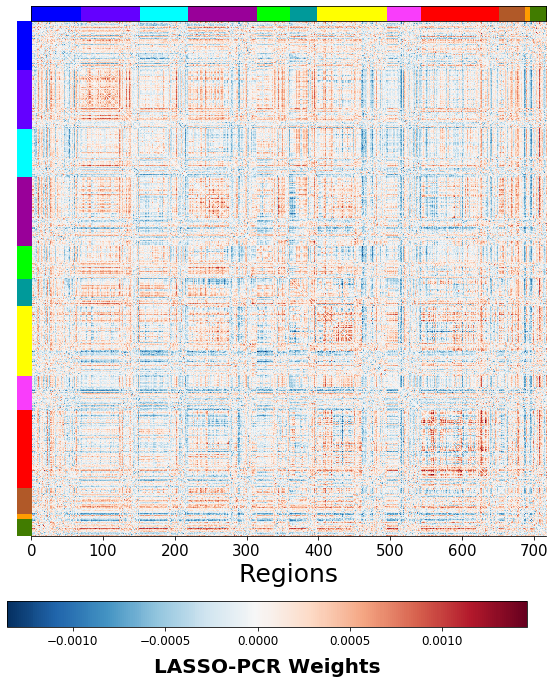

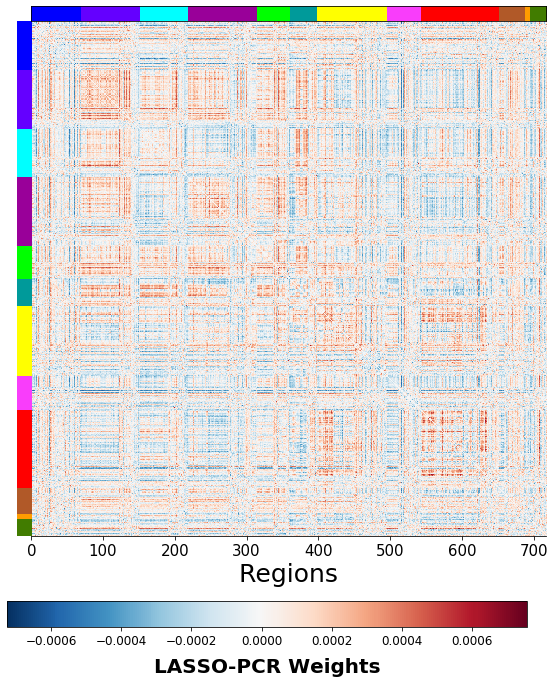

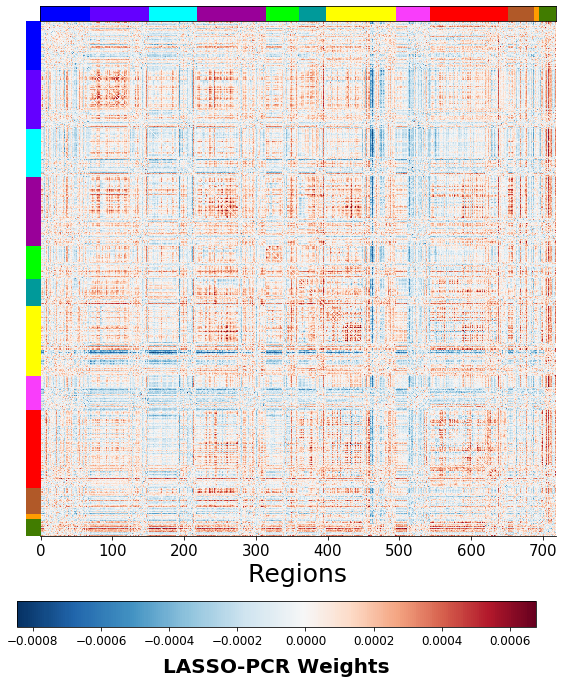

In [184]:
for score_name in ['CogTotalComp_Unadj', 
                   'CogFluidComp_Unadj',
                   'CogCrystalComp_Unadj']:
    
    plot_folder = Path(opj('../plots/', 'neurophenotypes', score_name))
    plot_folder.mkdir(parents=True, exist_ok=True)
    plot_folder = plot_folder.absolute().as_posix()
    
    w_conn = f[score_name]['CONNECTOME'][:]
    
    fcon_mat = squareform(w_conn) #compute_fcon(w_conn)

    fig = fc_figure(fcon_mat)
    plt.tight_layout()
    plt.savefig(opj(plot_folder, 'functional_mat.png'), dpi=300)

Save these networks to a table to plot using circos

In [200]:
import numpy.ma as ma 

In [209]:
foo = ma.masked_array(fcon_mat, fcon_mat>0)

In [485]:
def get_mean_rsn(conn_mat):
    
    """ Function to compute the mean weights 
        within and between intrinsic networks """
    
    rsn_weights = np.zeros((12, 12))
    n_rsn = 12
    #Construct the resting state network of mean weights
    for ii in range(n_rsn):
        for jj in range(ii, n_rsn):
                rsn_weights[ii, jj] = np.nanmean(conn_mat[netassignments==(ii+1),:][:, netassignments==(jj+1)])
                rsn_weights[jj, ii] =  rsn_weights[ii,jj]
    return rsn_weights

In [515]:
def get_rsn_weights(conn_mat):
    
    """ Function to compute the mean weights 
        within and between intrinsic networks """
    
    rsn_weights = []
    n_rsn = 12
    #Construct the resting state network of mean weights
    for ii in range(n_rsn):
        weights = conn_mat[netassignments==(ii+1),:]
        rsn_weights.append(weights[~np.isnan(weights)].flatten())
        
    return rsn_weights

In [858]:
def plot_rsn_weights(mean_pos_rsn, mean_neg_rsn):
    
    """ Function to plot the mean weights per RSN as barplots """
    
    from matplotlib.ticker import FormatStrFormatter
    
    x  = []
    x += list(np.arange(-15, -3)) # x-position for negative weights
    x += list(np.arange(1, 13)) # x-position for positive weights
    
    y  = [] 
    y += list(mean_neg_rsn[np.argsort(mean_neg_rsn)]) # y-position for negative weights
    y += list(mean_pos_rsn[np.argsort(mean_pos_rsn)]) # y-position for negative weights
    
    c  = []
    c += list(np.array(rsn_norm_colours)[np.argsort(mean_neg_rsn)]) # colours for negative weights 
    c += list(np.array(rsn_norm_colours)[np.argsort(mean_pos_rsn)]) # colours for positive weights 
    y = np.array(y)

    min_y = min(y)
    max_y = max(y)
    
    fig, ax = plt.subplots(figsize=(15,7))
    ax.bar(x,y, color=c, alpha=0.7)
    ax.scatter(x, y, c=c, s=200)

    ax.spines['left'].set_position('center')
    #ax.spines['bottom'].set_position(('axes', 0.455))
    ax.spines['bottom'].set_position(('data', 0.0))
    ax.set_xticks([])    
    ax.spines['top'].set_color("none")
    ax.spines['right'].set_color("none")

    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)
    ax.yaxis.set_major_formatter(formatter) 

    y_min, y_max = plt.gca().get_ylim()
    ax.tick_params("y", labelsize=20)
    ax.text( -1.2, y_min, s=r'$\times 10^{-4}$', size=20)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    
    return fig.tight_layout()
    

/home/javier/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/javier/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


CogTotalComp_Unadj
CogFluidComp_Unadj
CogCrystalComp_Unadj


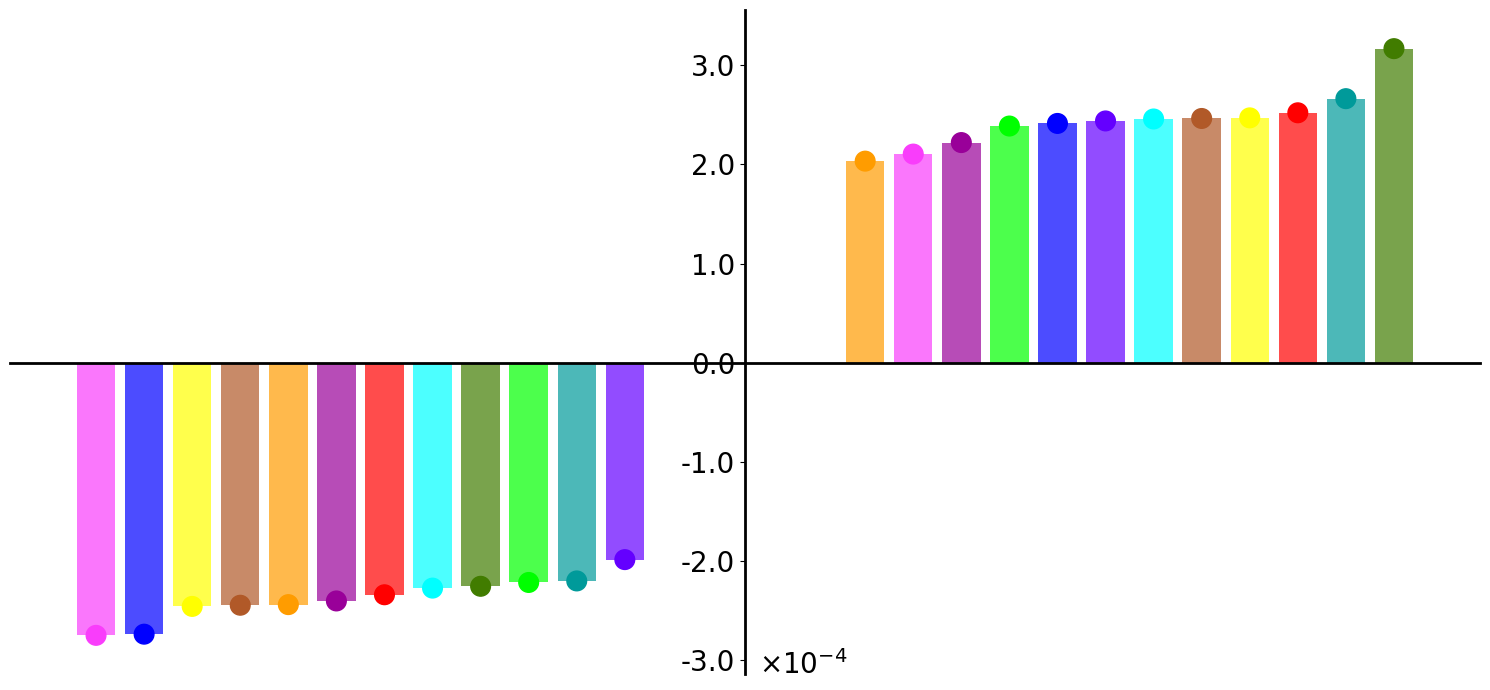

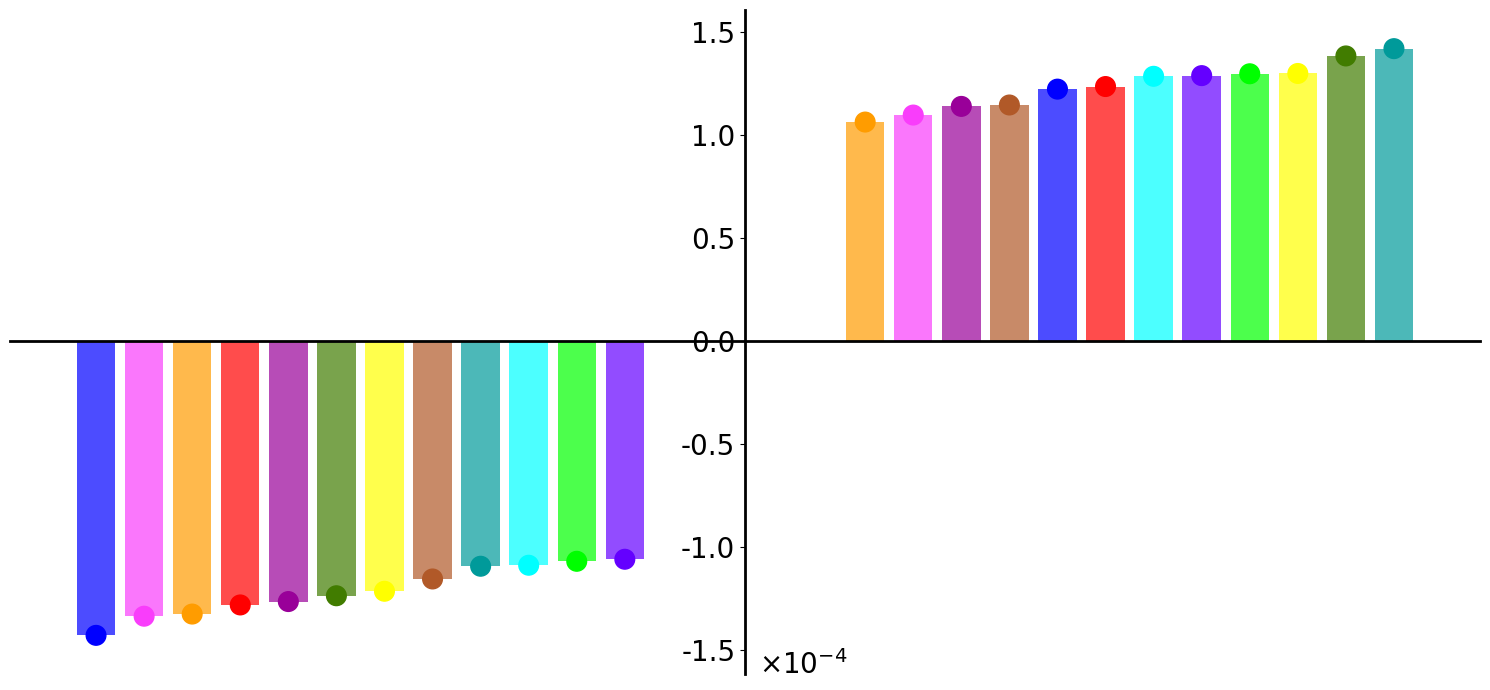

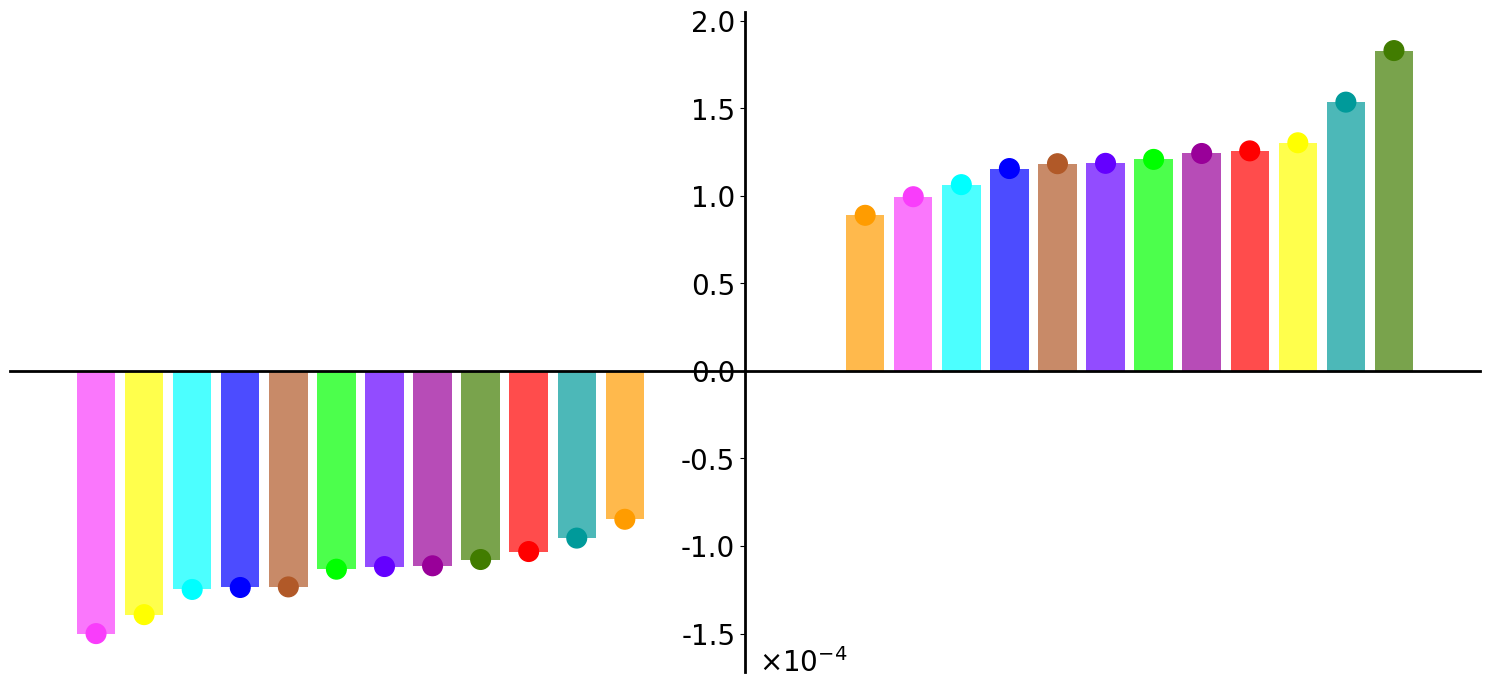

In [859]:
for ii, score_name in enumerate(['CogTotalComp_Unadj',
                                'CogFluidComp_Unadj', 
                                 'CogCrystalComp_Unadj']):
    
    plot_folder = Path(opj('../plots/', 'neurophenotypes', score_name))
    
    w_conn = f[score_name]['CONNECTOME'][:]
    
    fcon_mat = squareform(w_conn) #compute_fcon(w_conn)    
    # Make diagonal (they are zero) and upper triangular indices nan
    fcon_mat[np.triu_indices(fcon_mat.shape[0], k=0)] = np.nan
    
    ### POSITIVE WEIGHTS #####
    # Create matrix of positive weights and the negative set to nan
    weight_pos = fcon_mat.copy()
    weight_pos[weight_pos<0] = np.nan
    
    rsn_pos = get_rsn_weights(weight_pos)
    mean_pos_rsn = np.array([np.mean(ws) for ws in rsn_pos])*1e4
    
    ### NEGATIVE WEIGHTS #####
    # Create matrix of negative weights and the positive set to nan
    weight_neg = fcon_mat.copy()
    weight_neg[weight_neg>0] = np.nan
    
    rsn_neg = get_rsn_weights(weight_neg)
    mean_neg_rsn = np.array([np.mean(ws) for ws in rsn_neg])*1e4
    
    print(score_name)
    # Plot
    plot_rsn_weights(mean_pos_rsn, mean_neg_rsn)

# LOCAL CONNECTOME

Plotting **local connectome** neurophenotype for Cogntive composite, Fluig Cognition score, Crystallized Cognitive score, Penn Matrix and Penn Line orientation

In [884]:
def compute_loc_in_mni(lc_weights):
    
    """ set local connectome weights in MNI template """
    
    lc_img = np.zeros_like(mni152_template.get_fdata())
    
    # Add weights into to map location
    for ii, (x, y, z) in enumerate(voxel_location.astype(int)):
        lc_img[x, y, z] += lc_weights[ii]
    
    #Average over repeated voxels
    for x, y, z in zip(x_rep, y_rep, z_rep):
        lc_img[x,y,z] = lc_img[x, y, z]/rep_img[x, y, z]
        
    return lc_img

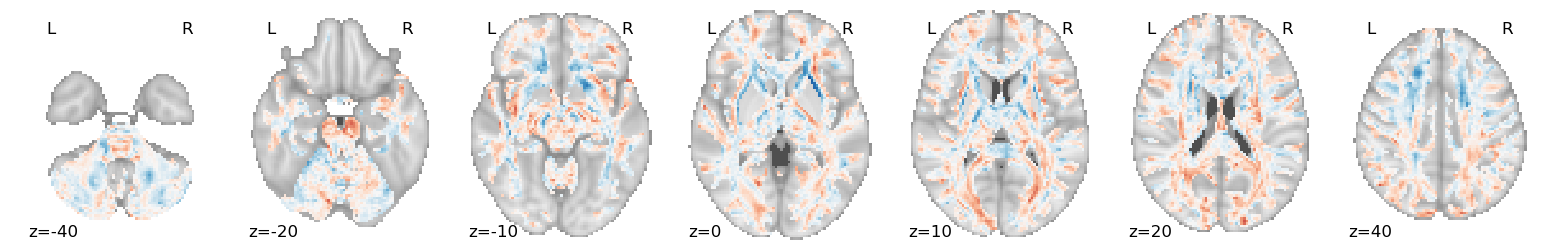

In [900]:
plotting.plot_stat_map(loc_mni_image, 
                           cmap=plt.cm.RdBu_r,
                           display_mode='z', 
                           black_bg=False, 
                       colorbar=False,
                       symmetric_cbar='auto',
                           cut_coords=(-40, -20, -10, 0, 10, 20, 40),
                          )

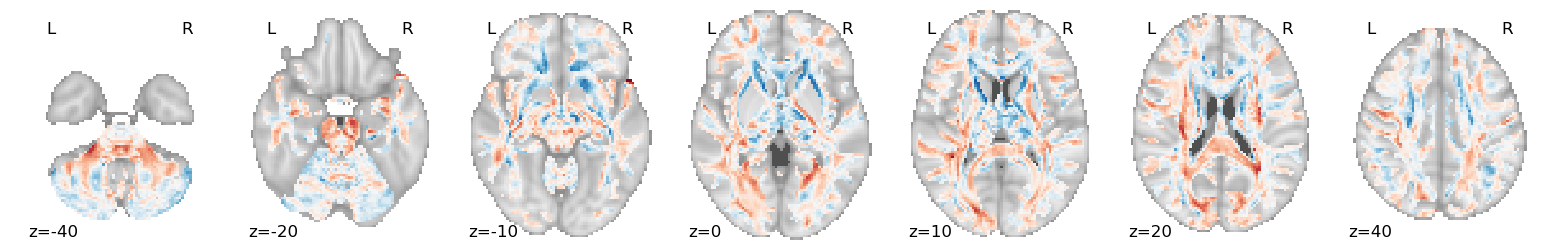

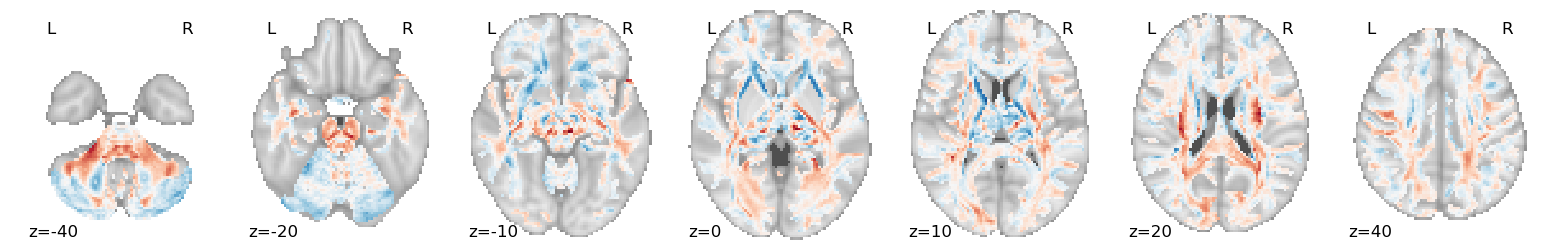

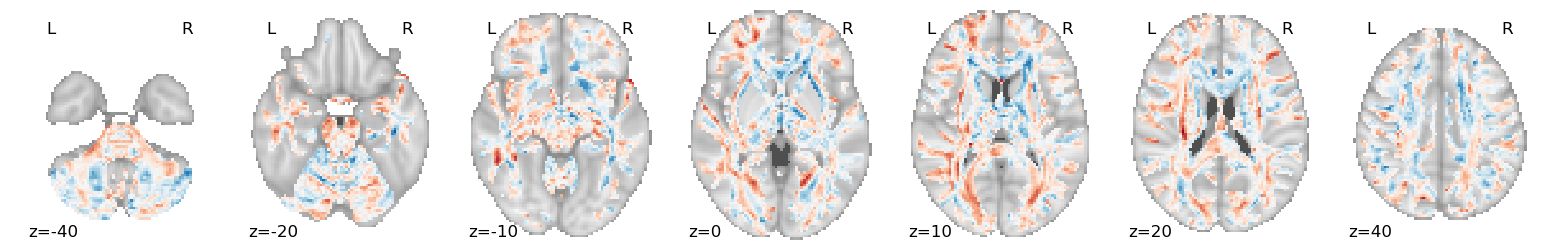

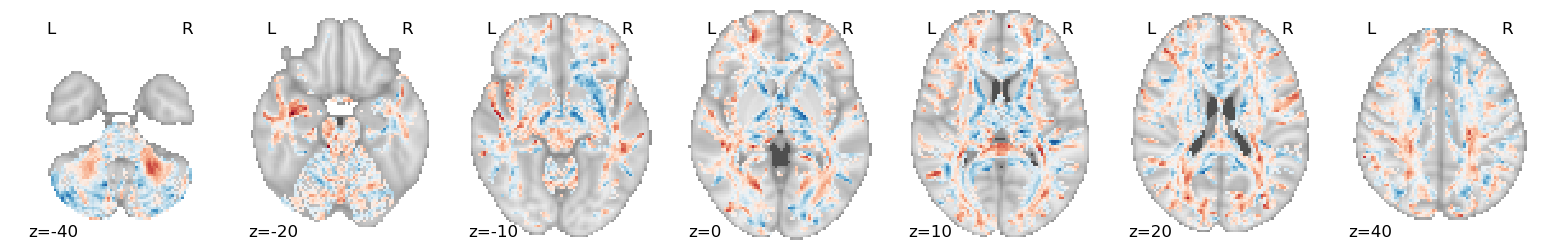

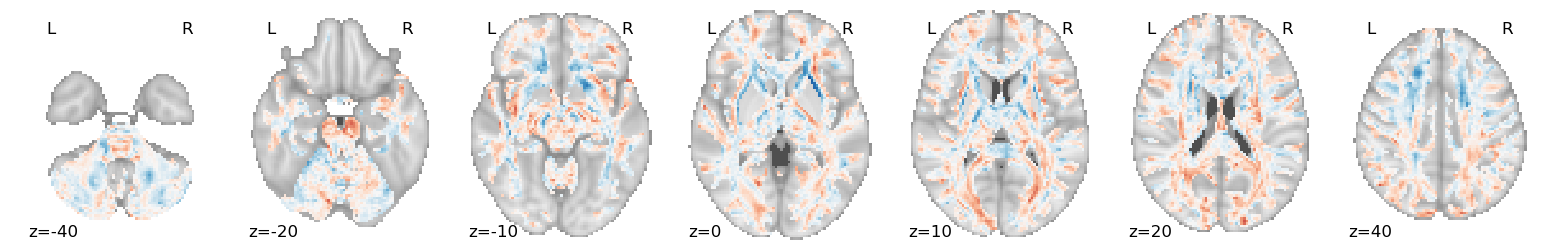

In [903]:
for score_name in ['CogTotalComp_Unadj',
                   'CogFluidComp_Unadj',
                   'CogCrystalComp_Unadj',
                   'DDisc_AUC_200',
                   'VSPLOT_TC']:
    
    # Plot folder
    plot_folder = Path(opj('../plots', 'neurophenotypes', score_name))
    plot_folder = plot_folder.absolute().as_posix()
    
    # Load weights
    w_loc = f[score_name]['LOCAL_CONN'][:]
    
    # Compute weighs in mni space
    loc_map = compute_loc_in_mni(w_loc)
    
    # Create an image in standard space with this data 
    loc_mni_image = image.new_img_like(mni152_template, loc_map)
    
    # Save to this image to upload to NeuroVault
    loc_mni_image.to_filename(opj("../images/", score_name, "%s_local_connectome.nii.gz" % score_name))
    
    # Plot this and save it to plot folder
    plotting.plot_stat_map(loc_mni_image, 
                           cmap=plt.cm.RdBu_r,
                           display_mode='z', 
                           black_bg=False, 
                           colorbar=False,
                           symmetric_cbar=True,
                           cut_coords=(-40, -20, -10, 0, 10, 20, 40)
                          )

    plt.savefig(opj(plot_folder, 'local_connectome.png'), dpi=300)

Compute the tract-wise averaged positive and negative weights using an atlas of white matter tracts (Yeh 2018).

In [121]:
columns = ['CogTotalComp_Unadj', 
           'CogFluidComp_Unadj', 
           'CogCrystalComp_Unadj',
           'DDisc_AUC_200',
           'VSPLOT_TC']

# We are going to separate into negative and positive weights
loc_pos_mean_atlas =  pd.DataFrame({}, columns=columns)
loc_neg_mean_atlas =  pd.DataFrame({}, columns=columns)

for ii in range(tract_atlas.shape[3]):
    tract_img = image.index_img(tract_atlas, ii)

    tract_img_152 = image.resample_to_img(tract_img, 
                                          mni152_template, 
                                          interpolation='nearest')
    
    tract_name = tract_atlas_labels.to_list()[ii]
    
    pos_score_values = []
    neg_score_values = []
    
    for score_name in columns:

        w_loc = f[score_name]['LOCAL_CONN'][:]
        loc_map = compute_loc_in_mni(w_loc)

        loc_152 = image.new_img_like(mni152_template, loc_map)
        
        loc_tract_data = image.math_img('img1*img2', 
                                       img1=loc_152, 
                                       img2=tract_img_152).get_fdata().copy()
        
        # You could use here maybe masked arrays
        pos_score_values.append(np.mean(loc_tract_data[loc_tract_data>0]))
        neg_score_values.append(np.mean(abs(loc_tract_data[loc_tract_data<0])))
        
    loc_pos_mean_atlas = loc_pos_mean_atlas.append(pd.DataFrame([pos_score_values], 
                                                                columns=columns))
    loc_neg_mean_atlas = loc_neg_mean_atlas.append(pd.DataFrame([neg_score_values], 
                                                                columns=columns))
    
    #If warning, that means that there's no weights on that tract

/home/javier/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/javier/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/javier/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/javier/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/javier/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/javier/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/javier/anaconda3/lib/python3.7/site-package

In [ ]:
columns = ['CogTotalComp_Unadj', 
           'CogFluidComp_Unadj', 
           'CogCrystalComp_Unadj',
           'DDisc_AUC_200',
           'VSPLOT_TC']

# We are going to separate into negative and positive weights
loc_pos_mean_atlas =  pd.DataFrame({}, columns=columns)
loc_neg_mean_atlas =  pd.DataFrame({}, columns=columns)

for ii in range(tract_atlas.shape[3]):
    tract_img = image.index_img(tract_atlas, ii)

    tract_img_152 = image.resample_to_img(tract_img, 
                                          mni152_template, 
                                          interpolation='nearest')
    
    tract_name = tract_atlas_labels.to_list()[ii]
    
    pos_score_values = []
    neg_score_values = []
    
    for score_name in columns:

        w_loc = f[score_name]['LOCAL_CONN'][:]
        loc_map = compute_loc_in_mni(w_loc)

        loc_152 = image.new_img_like(mni152_template, loc_map)
        
        loc_tract_data = image.math_img('img1*img2', 
                                       img1=loc_152, 
                                       img2=tract_img_152).get_fdata().copy()
        
        pos_score_values.append(np.mean(loc_tract_data[loc_tract_data>0]))
        neg_score_values.append(np.mean(abs(loc_tract_data[loc_tract_data<0])))
        
    loc_pos_mean_atlas = loc_pos_mean_atlas.append(pd.DataFrame([pos_score_values], 
                                                                columns=columns))
    loc_neg_mean_atlas = loc_neg_mean_atlas.append(pd.DataFrame([neg_score_values], 
                                                                columns=columns))
    
    #If warning, that means that there's no weights on that tract

In [123]:
loc_pos_mean_atlas.index=tract_atlas_labels
loc_pos_mean_atlas.index.name = 'Tracts'
loc_neg_mean_atlas.index=tract_atlas_labels
loc_neg_mean_atlas.index.name = 'Tracts'

Show the first 10 tracts with the largest positive and negative weights

In [125]:
# Positive weights
for col in loc_pos_mean_atlas.columns:
    print("--------------------")
    print(col)
    print("--------------------")
    print(100*loc_pos_mean_atlas.loc[:,col].sort_values(ascending=False)[:10])
    print(" ")

--------------------
CogTotalComp_Unadj
--------------------
Tracts
CNVII_L                             0.078350
Central_Tegmental_Tract_R           0.074156
CNVII_R                             0.070542
Medial_Longitudinal_Fasciculus_R    0.067753
CNIII_R                             0.066284
Rubrospinal_Tract_R                 0.061978
Medial_Longitudinal_Fasciculus_L    0.058947
Rubrospinal_Tract_L                 0.058049
Central_Tegmental_Tract_L           0.057871
Medial_Lemniscus_R                  0.055580
Name: CogTotalComp_Unadj, dtype: float64
 
--------------------
CogFluidComp_Unadj
--------------------
Tracts
Rubrospinal_Tract_R                 0.045209
CNVII_L                             0.045115
Central_Tegmental_Tract_R           0.044944
CNIII_R                             0.043966
CNVII_R                             0.041923
CNX_L                               0.041065
Medial_Longitudinal_Fasciculus_L    0.037879
Rubrospinal_Tract_L                 0.037686
Spinothalam

In [127]:
# Negative weights
for col in loc_neg_mean_atlas.columns:
    print("--------------------")
    print(col)
    print("--------------------")
    print(100*loc_neg_mean_atlas.loc[:,col].sort_values(ascending=False)[:10])
    print(" ")

--------------------
CogTotalComp_Unadj
--------------------
Tracts
Medial_Longitudinal_Fasciculus_R    0.049659
Fornix_R                            0.049574
CNV_L                               0.048798
Anterior_Commissure                 0.048780
Dorsal_Longitudinal_Fasciculus_R    0.048683
Cingulum_L                          0.048517
Cingulum_R                          0.048237
Uncinate_Fasciculus_R               0.047916
Superior_Cerebellar_Peduncle        0.047261
Optic_Radiation_L                   0.045995
Name: CogTotalComp_Unadj, dtype: float64
 
--------------------
CogFluidComp_Unadj
--------------------
Tracts
Acoustic_Radiation_R                      0.032517
Superior_Cerebellar_Peduncle              0.028808
Medial_Lemniscus_L                        0.025867
Dorsal_Longitudinal_Fasciculus_R          0.025672
Medial_Lemniscus_R                        0.025632
Optic_Radiation_L                         0.025427
Posterior_Commissure                      0.024922
Inferior_Front

Create a latex table from these results to copy to the manuscript

In [128]:
#Positive weights
print((np.round(loc_pos_mean_atlas*10**4, 3)).to_latex(index=True, na_rep="-", 
                                                       longtable=True, 
                                                       caption='mean positive weights'))

\begin{longtable}{lrrrrr}
\caption{mean positive weights}\\
\toprule
{} &  CogTotalComp\_Unadj &  CogFluidComp\_Unadj &  CogCrystalComp\_Unadj &  VSPLOT\_TC &  DDisc\_AUC\_200 \\
Tracts                                 &                     &                     &                       &            &                \\
\midrule
\endhead
\midrule
\multicolumn{6}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
Acoustic\_Radiation\_L                   &               5.441 &               2.622 &                 4.469 &      1.057 &          0.045 \\
Acoustic\_Radiation\_R                   &               4.682 &               3.112 &                 2.290 &      1.408 &          0.040 \\
Cortico\_Striatal\_Pathway\_L             &               3.678 &               1.625 &                 4.218 &      1.165 &          0.039 \\
Cortico\_Striatal\_Pathway\_R             &               3.445 &               1.755 &                 3.641 &      1.319 &          0

In [130]:
# Negative weights
print((np.round(loc_neg_mean_atlas*10**4, 3)).to_latex(index=True, na_rep="-", 
                                          longtable=True, 
                                          caption='mean negative weights'))

\begin{longtable}{lrrrrr}
\caption{mean negative weights}\\
\toprule
{} &  CogTotalComp\_Unadj &  CogFluidComp\_Unadj &  CogCrystalComp\_Unadj &  VSPLOT\_TC &  DDisc\_AUC\_200 \\
Tracts                                 &                     &                     &                       &            &                \\
\midrule
\endhead
\midrule
\multicolumn{6}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
Acoustic\_Radiation\_L                   &               4.337 &               2.388 &                 3.898 &      0.949 &          0.044 \\
Acoustic\_Radiation\_R                   &               4.441 &               3.252 &                 3.369 &      0.989 &          0.047 \\
Cortico\_Striatal\_Pathway\_L             &               3.920 &               1.808 &                 4.109 &      1.417 &          0.038 \\
Cortico\_Striatal\_Pathway\_R             &               3.762 &               1.677 &                 4.019 &      1.383 &          0

# CORTICAL SURFACE AREA

For Global Cogntive composite, Fluig Cognitive score, Crystallized Cognitive score, Delay Discounting and Penn Line orientation, pass **cortical surface area** neurophenotype to a txt file to then plot it using *wb_view* and save it as a nifti file for NeuroVault.

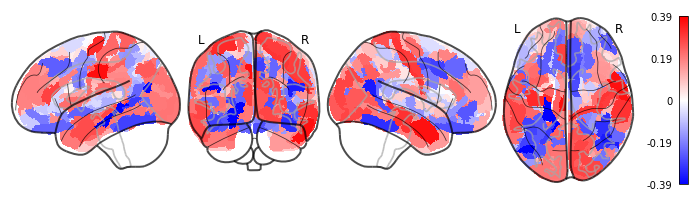

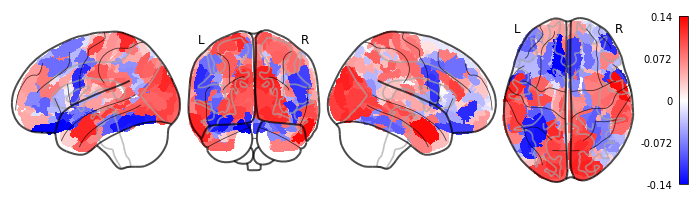

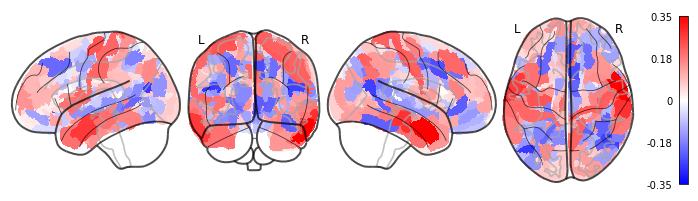

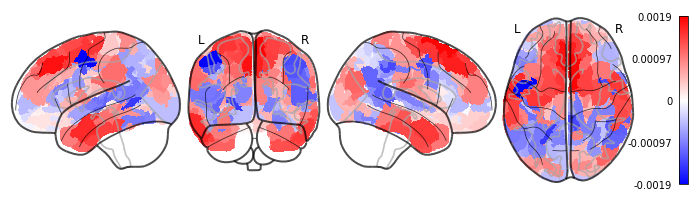

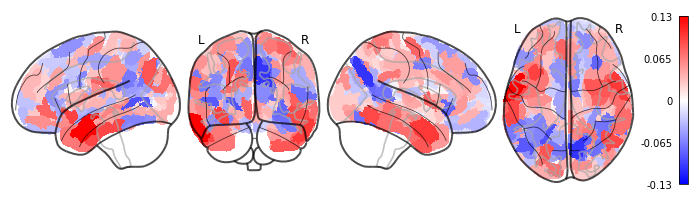

In [26]:
# Retrieve the parcellation label data in the volume version
cole_vol_data = cole_vol_img.get_fdata()

for score_name in ['CogTotalComp_Unadj',
                 'CogFluidComp_Unadj', 
                 'CogCrystalComp_Unadj',
                 'DDisc_AUC_200',
                 'VSPLOT_TC']:
    
    # Define plot folder
    plot_folder = Path(opj('../plots/', 'neurophenotypes', score_name))
    plot_folder = plot_folder.absolute().as_posix()
    
    w_surface = f[score_name]['SURFACE'][:]
    
    # Define a data frame with these weights and their labels according to Cole
    weights_df = pd.DataFrame({'parcel_label': parcel_labels[:360], 'weights': w_surface})
    
    # Save an additional txt file with the name of the ROI and the thickness value
    weights_df.to_csv(opj(plot_folder, 
                          score_name +'_surface_weights.txt'), sep = '\t', index=False)
    
    # save temp.txt adding zero values for subcortical parcels
    np.savetxt(opj(plot_folder, 'temp.txt'), np.concatenate((w_surface, 
                                                             np.zeros(718-len(w_surface)))))
    ## CIFTI FOR PLOTTING IN WB_VIEW ## 
    
    # In this command we are going to map these weights in the parcellation
    cmd = ["wb_command", 
           "-cifti-convert", 
           "-from-text", 
           opj(plot_folder, 'temp.txt'), 
           cole_pscalar_img,
           opj(plot_folder, score_name +'_surface_weights.pscalar.nii')
          ]
    subprocess.run(cmd)
    
    os.remove(opj(plot_folder, 'temp.txt'))
    
    ## NIFI FOR NEUROVAULT ## 
    
    # empty data where to map the weights in voxel space
    weight_data = np.zeros((cole_vol_img.shape))
    
    # Left hemisphere
    for (ii, w) in zip(range(1, 181), weights_df.iloc[:180, 1]):
        weight_data[cole_vol_data==ii] = w
        
    # Right hemisphere
    for (ii, w) in zip(range(201, 381), weights_df.iloc[180:, 1]):
        weight_data[cole_vol_data==ii] = w
        
    weights_in_vol = image.new_img_like(cole_vol_img, data=weight_data)
    # Save this to upload to neurovault
    weights_in_vol.to_filename(opj("../images/", 
                                   score_name, 
                                   "%s_surface_weights.nii.gz" % score_name))
    
    plotting.plot_glass_brain(weights_in_vol, 
                              display_mode='lyrz', 
                              cmap=plt.cm.bwr, 
                              plot_abs=False, 
                              colorbar=True)

Show the most important positive and negative weights for each of these

In [30]:
for score_name in ['CogTotalComp_Unadj',
                 'CogFluidComp_Unadj',
                 'CogCrystalComp_Unadj',
                'DDisc_AUC_200',
                   'VSPLOT_TC']:
    
    plot_folder = Path(opj('../plots/', 'neurophenotypes', score_name))
    
    print("---------------")
    print(score_name)
    print("---------------")
    print(pd.read_csv(opj(plot_folder, 
                          score_name +'_surface_weights.txt'), sep = '\t').sort_values(by='weights', 
                                                                                     ascending=False).head(10))
    print(" ")
    print(pd.read_csv(opj(plot_folder, 
                          score_name +'_surface_weights.txt'), sep = '\t').sort_values(by='weights').head(10))
    print("---------------")
    print(" ")

---------------
CogTotalComp_Unadj
---------------
                   parcel_label   weights
31             Default-40_L-Ctx  0.363575
311            Default-29_R-Ctx  0.361327
53         Somatomotor-32_L-Ctx  0.323525
309            Default-27_R-Ctx  0.310860
356     Frontoparietal-28_R-Ctx  0.310296
232        Somatomotor-11_R-Ctx  0.306200
188        Somatomotor-02_R-Ctx  0.295639
179  Cingulo-Opercular-56_L-Ctx  0.286911
129            Default-65_L-Ctx  0.284000
184            Visual2-04_R-Ctx  0.282447
 
                      parcel_label   weights
118               Default-62_L-Ctx -0.387247
140  Posterior-Multimodal-07_L-Ctx -0.383368
320  Posterior-Multimodal-04_R-Ctx -0.346706
197               Visual2-10_R-Ctx -0.315122
120               Visual1-05_L-Ctx -0.299236
239     Cingulo-Opercular-11_R-Ctx -0.288166
17                Visual2-37_L-Ctx -0.285783
220           Somatomotor-06_R-Ctx -0.269754
300               Visual1-02_R-Ctx -0.268584
272        Frontoparietal-17_R-Ctx 

# CORTICAL THICKNESS

For Global Cogntive composite, Fluig Cognitive score, Crystallized Cognitive score, Delay Discounting and Penn Line orientation, pass **cortical thickness** neurophenotype to a txt file to then plot it using *wb_view* and save it as a nifti file for NeuroVault.

In [882]:
from wbplot import pscalar

for score_name in ['CogTotalComp_Unadj',
                 'CogFluidComp_Unadj', 
                 'CogCrystalComp_Unadj',
                 'VSPLOT_TC']:
    w_thickness = f[score_name]['SURFACE'][:]
    pscalar("foo_%s.png" % score_name, w_thickness, cmap="RdBu_r",  orientation="portrait")

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


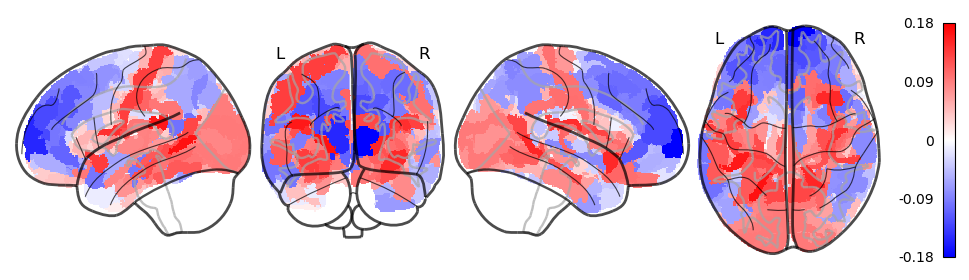

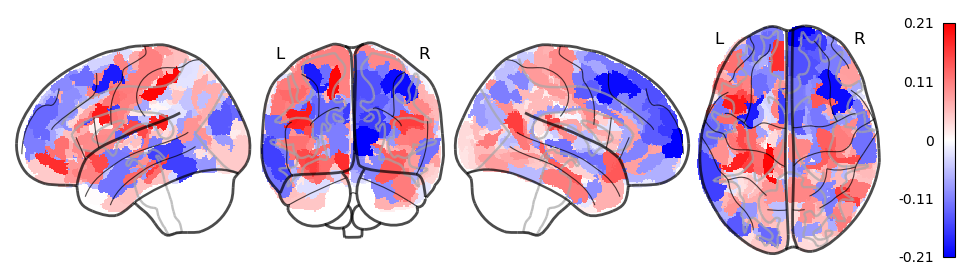

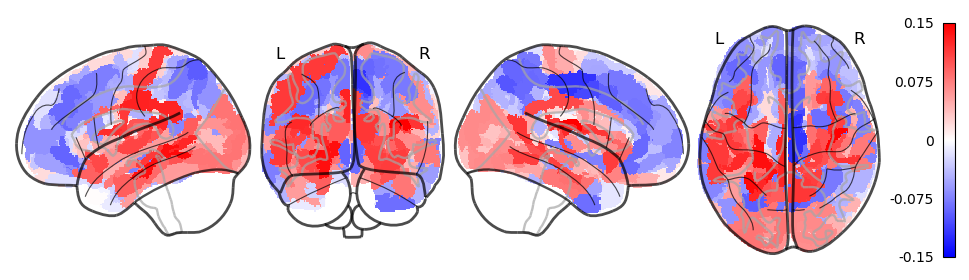

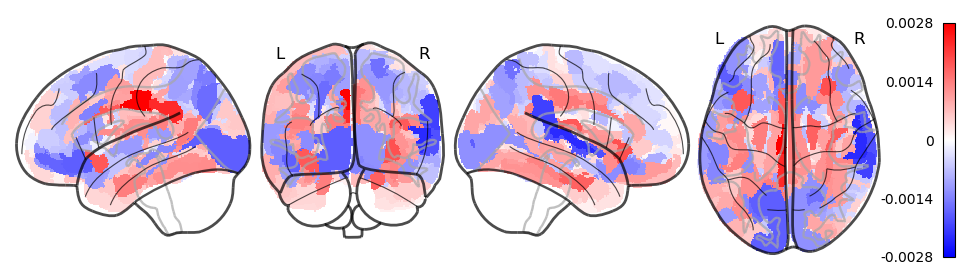

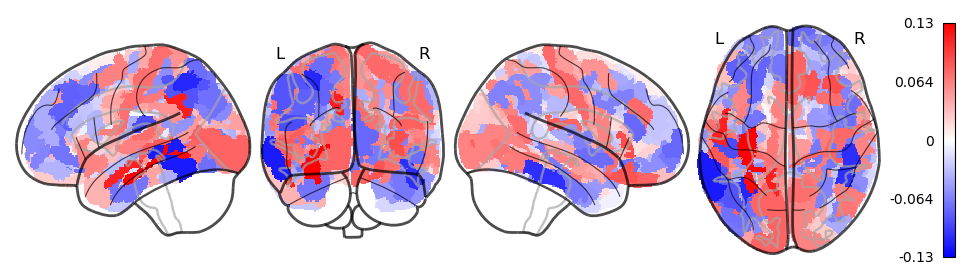

In [863]:
# Retrieve the parcellation label data in the volume version
cole_vol_data = cole_vol_img.get_fdata()

for score_name in ['CogTotalComp_Unadj',
                 'CogFluidComp_Unadj', 
                 'CogCrystalComp_Unadj',
                 'VSPLOT_TC']:
    
    # Define plot folder
    plot_folder = Path(opj('../plots/', 'neurophenotypes', score_name))
    plot_folder = plot_folder.absolute().as_posix()
    
    w_thickness = f[score_name]['THICKNESS'][:]
    
    # Define a data frame with these weights and their labels according to Cole
    weights_df = pd.DataFrame({'parcel_label': parcel_labels[:360], 'weights': w_thickness})
    
    # Save an additional txt file with the name of the ROI and the thickness value
    weights_df.to_csv(opj(plot_folder, 
                          score_name +'_thickness_weights.txt'), sep = '\t', index=False)
    
    # save temp.txt adding zero values for subcortical parcels
    np.savetxt(opj(plot_folder, 'temp.txt'), np.concatenate((w_thickness, 
                                                             np.zeros(718-len(w_surface)))))
    ## CIFTI FOR PLOTTING IN WB_VIEW ## 
    
    # In this command we are going to map these weights in the parcellation
    cmd = ["wb_command", 
           "-cifti-convert", 
           "-from-text", 
           opj(plot_folder, 'temp.txt'), 
           cole_pscalar_img,
           opj(plot_folder, score_name +'_thickness_weights.pscalar.nii')
          ]
    subprocess.run(cmd)
    
    os.remove(opj(plot_folder, 'temp.txt'))
    
    ## NIFI FOR NEUROVAULT ## 
    
    # empty data where to map the weights in voxel space
    weight_data = np.zeros((cole_vol_img.shape))
    
    # Left hemisphere
    for (ii, w) in zip(range(1, 181), weights_df.iloc[:180, 1]):
        weight_data[cole_vol_data==ii] = w
        
    # Right hemisphere
    for (ii, w) in zip(range(201, 381), weights_df.iloc[180:, 1]):
        weight_data[cole_vol_data==ii] = w
        
    weights_in_vol = image.new_img_like(cole_vol_img, data=weight_data)
    # Save this to upload to neurovaulr
    weights_in_vol.to_filename(opj("../images/", 
                                   score_name, 
                                   "%s_thickness_weights.nii.gz" % score_name))
    
    plotting.plot_glass_brain(weights_in_vol, 
                              display_mode='lyrz', 
                              cmap=plt.cm.bwr, 
                              plot_abs=False, 
                              colorbar=True)

In [86]:
for score_name in ['CogCrystalComp_Unadj', 
                 'CogFluidComp_Unadj',
                 'CogTotalComp_Unadj',
                 'VSPLOT_TC']:
    
    # Create folder
    plot_folder = Path(opj('../plots/', 'neurophenotypes', score_name))
    plot_folder = plot_folder.absolute().as_posix()
    
    w_thickness = f[score_name]['THICKNESS'][:]
    
    # save temp.txt adding zero values for subcortical volume
    np.savetxt(opj(plot_folder, 'temp.txt'), np.concatenate((w_thickness, 
                                                             np.zeros(718-len(w_thickness)))))
    
    cmd = ["wb_command", 
           "-cifti-convert", "-from-text", 
           opj(plot_folder, 'temp.txt'), 
           ,
           opj(plot_folder,  score_name +'_thickness_weights.pscalar.nii')
          ]
    subprocess.run(cmd)
    
    os.remove(opj(plot_folder, 'temp.txt'))
    
    # Save an additional txt file with the name of the ROI and the thickness value
    pd.DataFrame({'parcel_label': parcel_labels[:360], 
                  'weights': w_thickness}).to_csv(opj(plot_folder, score_name +'_thickness_weights.txt'),
                                                                                    sep = '\t', index=False)

In [154]:
for score_name in ['CogTotalComp_Unadj',
                   'CogFluidComp_Unadj', 
                   'CogCrystalComp_Unadj',
                   'VSPLOT_TC']:
    print(score_name)
    plot_folder = Path(opj('../plots/', 'neurophenotypes', score_name))

    print(pd.read_csv(opj(plot_folder, 
                          score_name +'_thickness_weights.txt'), sep = '\t').sort_values(by='weights', 
                                                                                     ascending=False).head(10))
    print(pd.read_csv(opj(plot_folder, 
                          score_name +'_thickness_weights.txt'), sep = '\t').sort_values(by='weights').head(10))
    print(" ")

CogTotalComp_Unadj
                   parcel_label   weights
120            Visual1-05_L-Ctx  0.166424
103           Auditory-10_L-Ctx  0.161008
300            Visual1-02_R-Ctx  0.151596
291   Orbito-Affective-02_R-Ctx  0.150503
281        Somatomotor-17_R-Ctx  0.146719
113  Cingulo-Opercular-49_L-Ctx  0.145697
111   Orbito-Affective-05_L-Ctx  0.136741
8          Somatomotor-22_L-Ctx  0.134934
283        Somatomotor-18_R-Ctx  0.133780
293  Cingulo-Opercular-22_R-Ctx  0.130844
                   parcel_label   weights
251            Default-16_R-Ctx -0.179194
71             Default-54_L-Ctx -0.151772
86             Default-56_L-Ctx -0.126556
248            Default-13_R-Ctx -0.126083
266            Default-18_R-Ctx -0.120906
83   Cingulo-Opercular-41_L-Ctx -0.117737
240            Default-07_R-Ctx -0.116579
250            Default-15_R-Ctx -0.116578
239  Cingulo-Opercular-11_R-Ctx -0.108748
60             Default-44_L-Ctx -0.107843
 
CogFluidComp_Unadj
                      parcel_label  

### Subcortical volumes

In [20]:
import glob
pd.read_csv(glob.glob(opj(data_dir, "final", "structural","*", "sub_volumes.txt"))[0], sep='\t').iloc[:,0].values

array(['Left-Lateral-Ventricle', 'Left-Inf-Lat-Vent',
       'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex',
       'Left-Thalamus-Proper', 'Left-Caudate', 'Left-Putamen',
       'Left-Pallidum', '3rd-Ventricle', '4th-Ventricle', 'Brain-Stem',
       'Left-Hippocampus', 'Left-Amygdala', 'CSF', 'Left-Accumbens-area',
       'Left-VentralDC', 'Left-vessel', 'Left-choroid-plexus',
       'Right-Lateral-Ventricle', 'Right-Inf-Lat-Vent',
       'Right-Cerebellum-White-Matter', 'Right-Cerebellum-Cortex',
       'Right-Thalamus-Proper', 'Right-Caudate', 'Right-Putamen',
       'Right-Pallidum', 'Right-Hippocampus', 'Right-Amygdala',
       'Right-Accumbens-area', 'Right-VentralDC', 'Right-vessel',
       'Right-choroid-plexus', '5th-Ventricle', 'WM-hypointensities',
       'Left-WM-hypointensities', 'Right-WM-hypointensities',
       'non-WM-hypointensities', 'Left-non-WM-hypointensities',
       'Right-non-WM-hypointensities', 'Optic-Chiasm', 'CC_Posterior',
       'CC_Mid_Posterio

In [935]:
aparc_aseg = nib.load('../data/aparcaseg_mni_neurovault_23262.nii.gz') 
aparc_aseg_data = aparc_aseg.get_fdata()
aparc_aseg_labels = np.unique(aparc_aseg_data).astype(int)

In [937]:
aparc_aseg_labels

array([   0,    2,    4,    5,    7,    8,   10,   11,   12,   13,   14,
         15,   16,   17,   18,   24,   26,   28,   30,   31,   41,   43,
         44,   46,   47,   49,   50,   51,   52,   53,   54,   58,   60,
         62,   63,   77,   85,  251,  252,  253,  254,  255, 1000, 1001,
       1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011, 1012,
       1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023,
       1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034,
       1035, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031,
       2032, 2033, 2034, 2035])

In [939]:
with open('/usr/local/freesurfer/FreeSurferColorLUT.txt') as free_lut:
    lines = free_lut.readlines()

In [940]:
aparc_aseg_labels_names = {}
for line in lines:
    line = line.split()
    try:
        if int(line[0]) in aparc_aseg_labels:
            name = line[1]
            aparc_aseg_labels_names[name] = int(line[0])
    except:
        continue

In [941]:
aparc_aseg_labels_names

{'Unknown': 0,
 'Left-Cerebral-White-Matter': 2,
 'Left-Lateral-Ventricle': 4,
 'Left-Inf-Lat-Vent': 5,
 'Left-Cerebellum-White-Matter': 7,
 'Left-Cerebellum-Cortex': 8,
 'Left-Thalamus-Proper': 10,
 'Left-Caudate': 11,
 'Left-Putamen': 12,
 'Left-Pallidum': 13,
 '3rd-Ventricle': 14,
 '4th-Ventricle': 15,
 'Brain-Stem': 16,
 'Left-Hippocampus': 17,
 'Left-Amygdala': 18,
 'CSF': 24,
 'Left-Accumbens-area': 26,
 'Left-VentralDC': 28,
 'Left-vessel': 30,
 'Left-choroid-plexus': 31,
 'Right-Cerebral-White-Matter': 41,
 'Right-Lateral-Ventricle': 43,
 'Right-Inf-Lat-Vent': 44,
 'Right-Cerebellum-White-Matter': 46,
 'Right-Cerebellum-Cortex': 47,
 'Right-Thalamus-Proper': 49,
 'Right-Caudate': 50,
 'Right-Putamen': 51,
 'Right-Pallidum': 52,
 'Right-Hippocampus': 53,
 'Right-Amygdala': 54,
 'Right-Accumbens-area': 58,
 'Right-VentralDC': 60,
 'Right-vessel': 62,
 'Right-choroid-plexus': 63,
 'WM-hypointensities': 77,
 'Optic-Chiasm': 85,
 'CC_Posterior': 251,
 'CC_Mid_Posterior': 252,
 'CC_C

In [944]:
# A few features are discarded because they are mainly the same
vol_features_support = pd.read_csv('../data/vol_features_support.csv', sep='\t')
vol_features_weights = f['DDisc_AUC_200']['SUB_VOLUMES'][:]

In [946]:
vol_features_weights.shape

(62,)

In [947]:
vol_pheno_weight={}
for name, weight in zip(vol_features_support.measure[vol_features_support.included].values,
                        vol_features_weights):
    vol_pheno_weight[name] = weight

In [948]:
vol_pheno_weight

{'Left-Lateral-Ventricle': 0.0049509230240856366,
 'Left-Inf-Lat-Vent': -0.005393798243073608,
 'Left-Cerebellum-White-Matter': 0.012979433968682997,
 'Left-Cerebellum-Cortex': -0.0015223252123005176,
 'Left-Thalamus-Proper': -0.00524895223577677,
 'Left-Caudate': 0.0023961083843473613,
 'Left-Putamen': -0.007108562837184005,
 'Left-Pallidum': 0.0009995692652156906,
 '3rd-Ventricle': -0.004684622011375646,
 '4th-Ventricle': 0.008716610898748155,
 'Brain-Stem': 0.0029574168524409217,
 'Left-Hippocampus': 0.0003285429921789044,
 'Left-Amygdala': 0.005821019617363109,
 'CSF': 0.006599311606106878,
 'Left-Accumbens-area': -0.014673090555730522,
 'Left-VentralDC': 0.013798910152214905,
 'Left-vessel': 0.001129022364783734,
 'Left-choroid-plexus': -0.0010783885505657607,
 'Right-Lateral-Ventricle': 0.010318897400510365,
 'Right-Inf-Lat-Vent': 0.0027529098302952566,
 'Right-Cerebellum-White-Matter': -0.012078151852175745,
 'Right-Cerebellum-Cortex': -0.0004474552124085337,
 'Right-Thalamus-Pr

In [949]:
#map each index with a weight
index_map = {}
name_map = {}
for name, beta in vol_pheno_weight.items():
    try:
        index_map[aseg_labels_names[name]] = beta
        name_map[name] = beta
    except:
        print(name)
        continue

5th-Ventricle
non-WM-hypointensities
BrainSegVol
BrainSegVolNotVent
BrainSegVolNotVentSurf
lhCortexVol
rhCortexVol
CortexVol
lhCorticalWhiteMatterVol
rhCorticalWhiteMatterVol
CorticalWhiteMatterVol
SubCortGrayVol
TotalGrayVol
SupraTentorialVol
SupraTentorialVolNotVent
SupraTentorialVolNotVentVox
MaskVol
BrainSegVol-to-eTIV
MaskVol-to-eTIV
lhSurfaceHoles
rhSurfaceHoles
SurfaceHoles
EstimatedTotalIntraCranialVol


In [184]:
pd.DataFrame({'name':list(name_map.keys()), 'value':list(name_map.values())}).sort_values(by='value')

name     value
14            Left-Accumbens-area -0.014673
38                    CC_Anterior -0.013259
20  Right-Cerebellum-White-Matter -0.012078
25                 Right-Pallidum -0.010930
33                   Optic-Chiasm -0.010261
26              Right-Hippocampus -0.009197
31           Right-choroid-plexus -0.007678
6                    Left-Putamen -0.007109
27                 Right-Amygdala -0.006690
24                  Right-Putamen -0.005477
1               Left-Inf-Lat-Vent -0.005394
4            Left-Thalamus-Proper -0.005249
8                   3rd-Ventricle -0.004685
22          Right-Thalamus-Proper -0.002689
34                   CC_Posterior -0.002304
3          Left-Cerebellum-Cortex -0.001522
17            Left-choroid-plexus -0.001078
21        Right-Cerebellum-Cortex -0.000447
11               Left-Hippocampus  0.000329
7                   Left-Pallidum  0.001000
16                    Left-vessel  0.001129
37                CC_Mid_Anterior  0.001909
5                    Left-Caudate  0.002396
23                  Right-Caudate  0.002452
19             Right-Inf-Lat-Vent  0.002753
10                     Brain-Stem  0.002957
32             WM-hypointensities  0.003074
36                     CC_Central  0.003990
30                   Right-vessel  0.004450
0          Left-Lateral-Ventricle  0.004951
12                  Left-Amygdala  0.005821
29                Right-VentralDC  0.006001
28           Right-Accumbens-area  0.006029
13                            CSF  0.006599
9                   4th-Ventricle  0.008717
18        Right-Lateral-Ventricle  0.010319
35               CC_Mid_Posterior  0.012187
2    Left-Cerebellum-White-Matter  0.012979
15                 Left-VentralDC  0.013799

In [173]:
akeys = np.fromiter(ma.keys(), dtype=float)
vals = np.fromiter(Samples.values(), dtype=float)

array(dict_values([0.0049509230240856366, -0.005393798243073608, 0.012979433968682997, -0.0015223252123005176, -0.00524895223577677, 0.0023961083843473613, -0.007108562837184005, 0.0009995692652156906, -0.004684622011375646, 0.008716610898748155, 0.0029574168524409217, 0.0003285429921789044, 0.005821019617363109, 0.006599311606106878, -0.014673090555730522, 0.013798910152214905, 0.001129022364783734, -0.0010783885505657607, 0.010318897400510365, 0.0027529098302952566, -0.012078151852175745, -0.0004474552124085337, -0.002689249384908486, 0.0024521595309426234, -0.005476678042512498, -0.010929512539965377, -0.009197231436197177, -0.006689650820871519, 0.0060286799696048395, 0.006000914763692928, 0.004449577807830683, -0.007677869572756424, 0.0030740369991958125, -0.010261266898665427, -0.0023043957387660534, 0.01218723707840059, 0.003990314747543291, 0.0019091948422529205, -0.013259057288292866]),
      dtype=object)

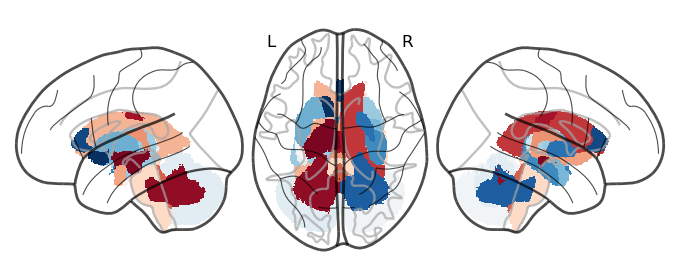

In [955]:
 # Create empty array with the aparc_aseg where we are going to map the weights
pheno_img_data = np.zeros(aparc_aseg.shape)

# fill this array with the weights
for index, weight in index_map.items():
    pheno_img_data[aparc_aseg_data==index] = weight
    
# Create the image
pheno_img = image.new_img_like(aparc_aseg, data=pheno_img_data)

# Save this image for neuroVault
pheno_img.to_filename(opj("../images/", 
                          'DDisc_AUC_200', 
                          "%s_volume_weights.nii.gz" % 'DDisc_AUC_200'))

# Plot this image as a glass brain
plotting.plot_glass_brain(pheno_img, 
                          colorbar=False, 
                          plot_abs=False, 
                          cmap=plt.cm.RdBu_r, display_mode='lzr', 
                          symmetric_cbar=True)

# CORRELATION BETWEEN PHENOTYPES (FIGURE S3)

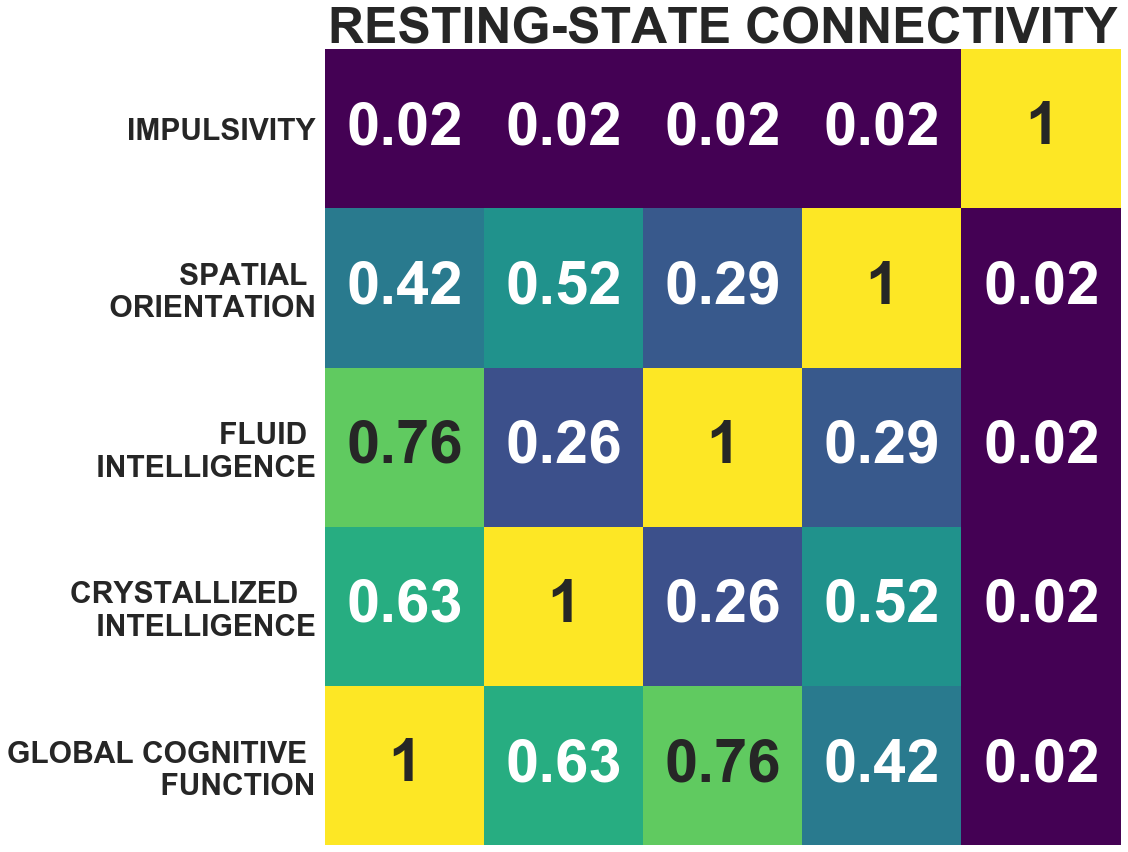

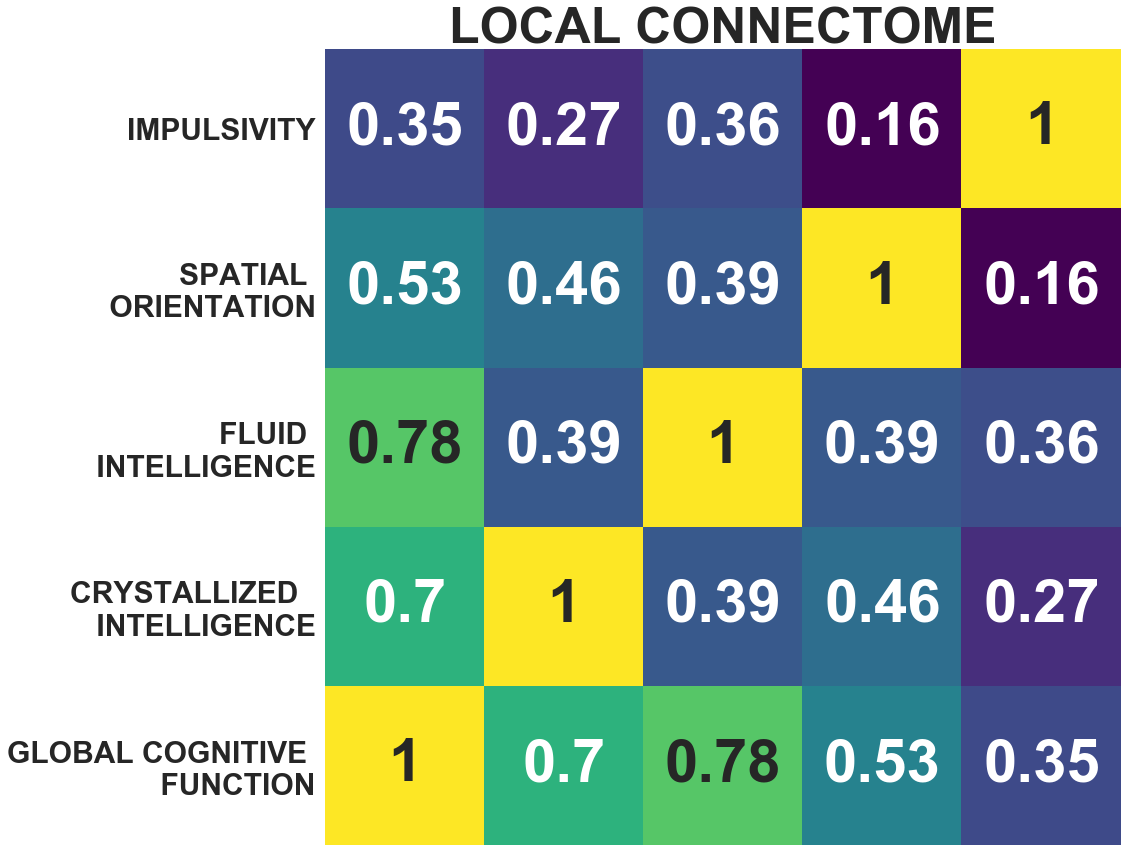

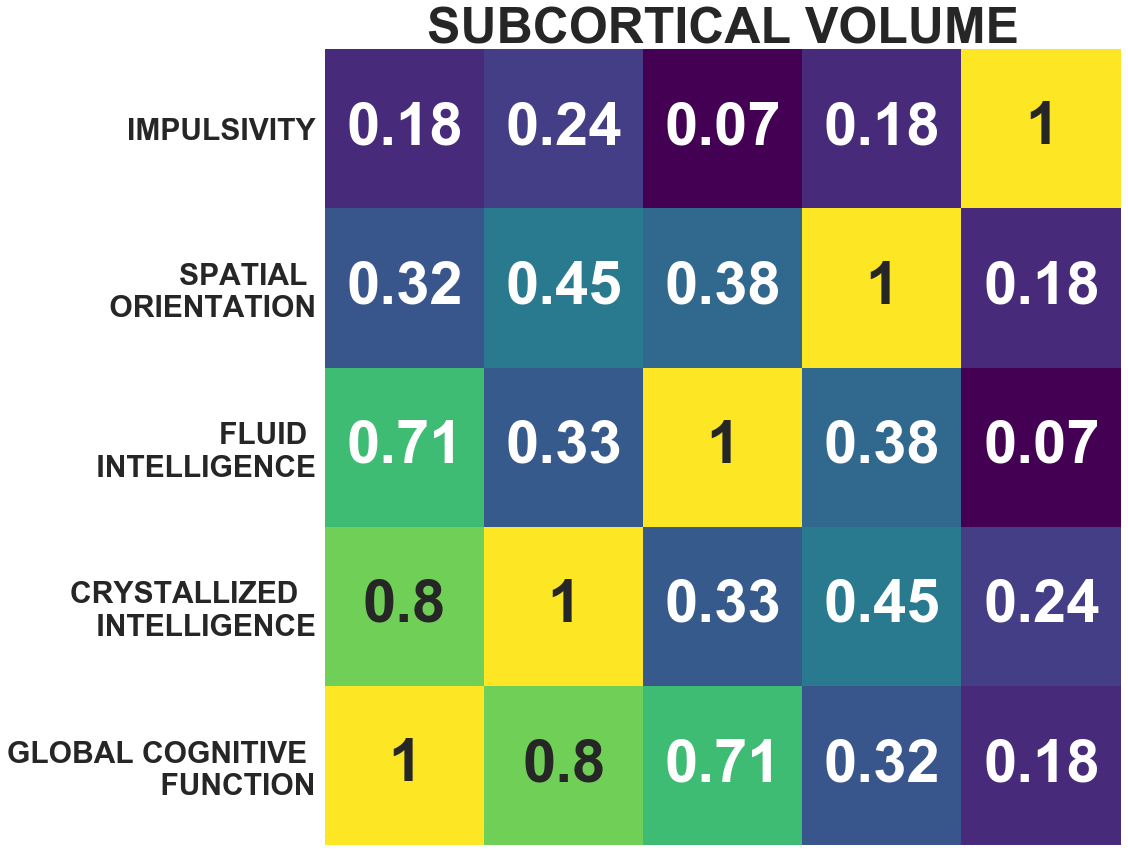

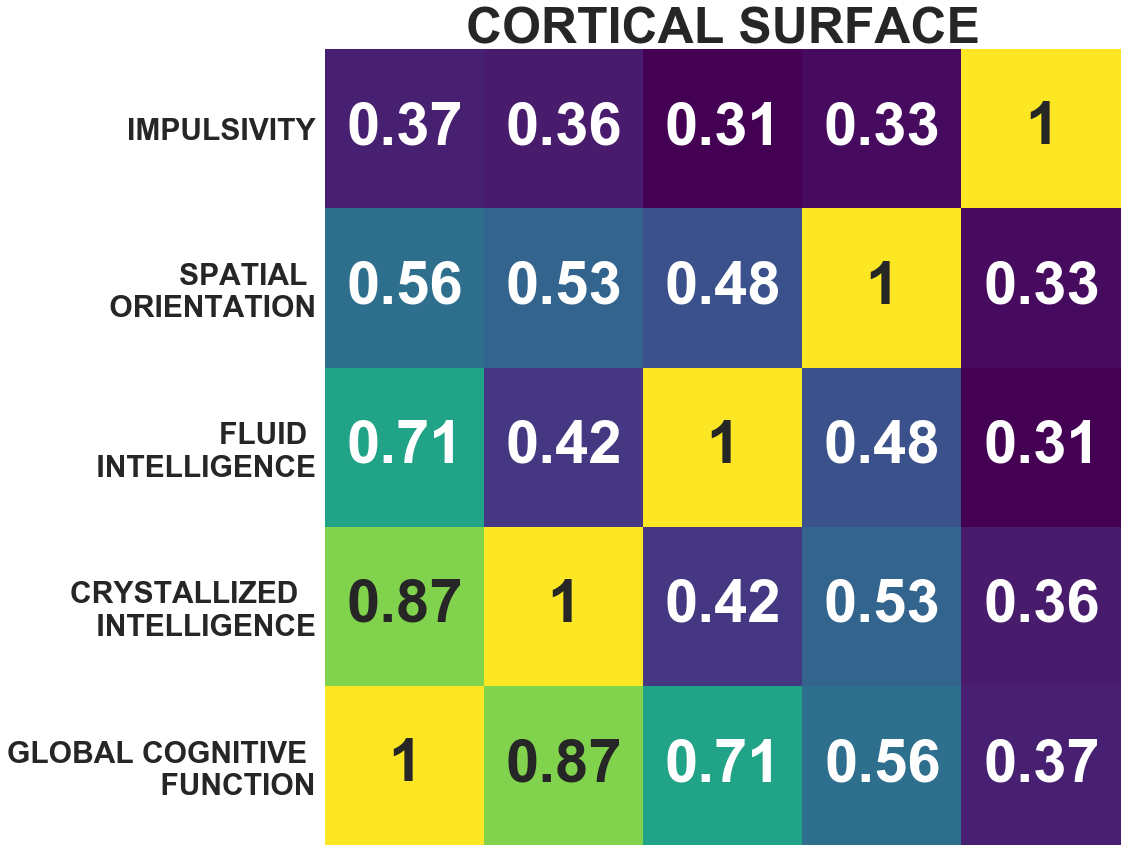

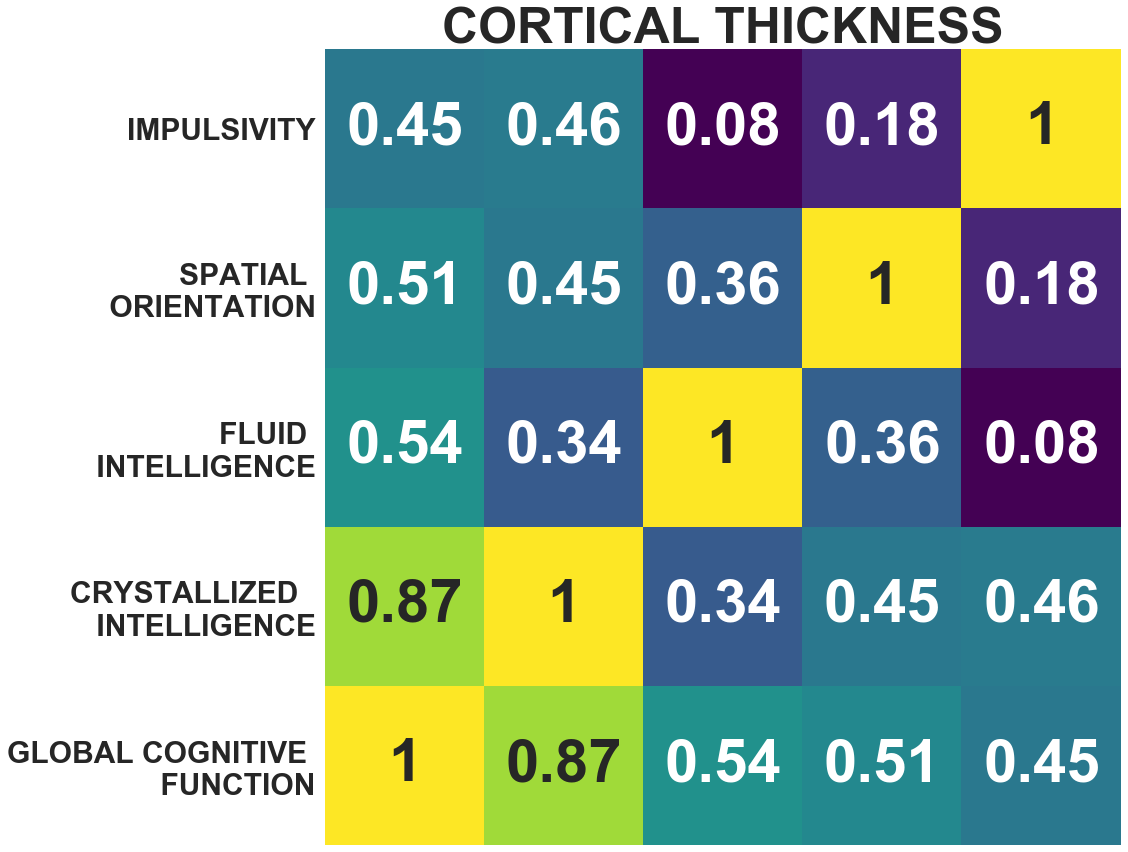

In [8]:
for mod in f['CogTotalComp_Unadj'].keys():

    if mod=='CONNECTOME':
        mod_name = 'RESTING-STATE CONNECTIVITY'
    elif mod=='LOCAL_CONN':
        mod_name =   'LOCAL CONNECTOME'
    elif mod == 'SUB_VOLUMES':
        mod_name = 'SUBCORTICAL VOLUME'
    elif mod == 'SURFACE':
        mod_name = 'CORTICAL SURFACE'
    elif mod == 'THICKNESS':
         mod_name = 'CORTICAL THICKNESS'
    else:
        continue

    plt.figure(figsize=(24, 12))
    cor_mat = np.corrcoef(np.vstack([f['CogTotalComp_Unadj'][mod][:], 
                                     f['CogCrystalComp_Unadj'][mod][:],
                                     f['CogFluidComp_Unadj'][mod][:],
                                     f['VSPLOT_TC'][mod][:],
                                     f['DDisc_AUC_200'][mod][:]]))
    sns.heatmap(np.round(cor_mat,2), 
                cmap=plt.cm.viridis, 
                cbar=False,
                annot=True, 
                square=True, 
                annot_kws={'size':60, 'weight':'bold'})
    labels = ['GLOBAL COGNITIVE \n FUNCTION', 
              'CRYSTALLIZED  \n INTELLIGENCE',
              'FLUID \n INTELLIGENCE', 
              'SPATIAL \n ORIENTATION',
             'IMPULSIVITY']
    plt.yticks([0.5, 1.5,2.5, 3.5, 4.5], 
               labels=labels,
               size=30,
               rotation=0, weight='bold')
    plt.xticks([])
    plt.ylim([0, 5.])
    plt.title(mod_name, size=50, weight='bold')
    plt.tight_layout()
    #plt.savefig(opj(pheno_plot_folder,'corrs_phen_chan_%s.svg') % mod, dpi=300)
    #plt.savefig(opj(pheno_plot_folder,'corrs_phen_chan_%s.png') % mod, dpi=300)